![book header](pictures/header.png)

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from serial import Serial # Uncomment this line if you are using the real car
from pyaudio import PyAudio, paInt16 # Uncomment this line if you are using the real car
# from KITT_Simulator.py_audio_simulator import PyAudio, paInt16 # Uncomment this line if you are using the simulator
# from KITT_Simulator.serial_simulator import Serial # Uncomment this line if you are using the simulator

# Module 2 - Reading KITT Sensor Data

KITT relies on its sensors to drive autonomously. It is equipped with:
1. Two front-mounted distance sensors.
2. Five microphones positioned around the field to record audio signals from KITT's beacon and relay them to the soundcard after which they can be read by your PC.

This task focuses on reading data from the distance sensors to avoid obstacles and processing the microphone data from the field.

**Preparation**
- Ensure KITT is operational and properly set up.
- Reserve time for testing on a field equipped with microphones and an audio card.
- For Windows 10 users, install ASIO4ALL and use a PyAudio build compatible with ASIO.
- For Mac users, install PyAudio using Homebrew.
 
 ---

## 1. Distance Sensors

KITT’s front distance sensors use ultrasonic technology. Two SRF02 modules, mounted on the left and right sides, measure the distance to obstacles. These sensors work by emitting a 40 kHz pulse and measuring the time it takes for the echo to return. This time is converted into a distance measurement.

- Each sensor requires a minimum of 66 ms between readings, as specified in the SRF02 datasheet (available at: Files/Datasheets/srf02.pdf).
- The system is configured with a 70 ms cycle time, during which the left and right sensors take turns recording measurements.
- These measurements are stored in a buffer on KITT's microcontroller, with each new reading overwriting the previous one.

<img src="pictures/srf02-ultrasonic-sensor.jpg" alt="Ultrasonic Sensor" width="400" height="240">

To ensure you can experiment at home, we have added the status command to the simulator. The simulator will accurately simulate the sensor distances, but not its behavior. Make sure to test on the real car frequently.

### Step 1: Status Command

You can ask KITT to capture a status command by writing "S\n" to the serial port. Then you have to read the message using "read_until", this will generate a binary message that you need to decode. KITT always ends it's message with the end-of-transmission character (0x04). The response contains 3 sections. 
1) Audio Beacon status and settings
2) PWM values for the motors
3) Sensor readings

In [16]:
serial = Serial('/dev/ttyUSB0', 115200)
time.sleep(0.1) # Wait for the serial to open
serial.write(b'S\n')
status = serial.read_until(b'\x04').decode('utf-8')
print(status)
serial.close()

Canvas(height=520, width=520)

**************************
* Audio Beacon: on
* c: 0xabcdef00
* f_c: 5678
* f_b: 1234
* c_r: 1337
**************************
* PWM:
* Dir. 150
* Mot. 150
**************************
* Sensors:
* Dist. L 420.0 R 420.0
* V_batt 11.5 V
**************************



### Isolating Specific Data from KITT

If you only need specific information, such as the distance measurements, battery voltage, or version information, you can request them separately:

- **For distance measurements only**: Use the command:
  ```python
  serial_port.write(b'Sd\n')
  ```
  This returns only the left and right distance sensor values, filtering out the rest of the status report.

- **For battery voltage**: Use the command:
  ```python
  serial_port.write(b'Sv\n')
  ```
  This command returns just the battery voltage level.

- **For version information**: Use the command:
  ```python
  serial_port.write(b'V\n')
  ```
  This sends back the version details of KITT’s firmware.

### Step 2: Extracting and Isolating Distance Data

Once you have received the status information from KITT, you can extract and isolate the distance sensor readings (left and right) from the full status report.

#### Code to Extract Distance Data:

After sending the status command (`b'S\n'`), the response will contain a variety of information, including the distance measurements. Now write a Python function to extract the distance data from the status report.

1. **Send the Status Command** to receive the full status report:

In [18]:
serial = Serial('/dev/ttyUSB0', 115200)
time.sleep(0.1)
serial.write(b'S\n')
status = serial.read_until(b'\x04')
serial.close()

Canvas(height=520, width=520)

2. **Extract the Distance Measurements**:
   The distance values are typically embedded in the `Sensors` section of the status response. You can process the `status` output to isolate just the left (`L`) and right (`R`) distance sensor values . Write a function to extract these values.

In [19]:
# Convert the status response to a string
status_str = status.decode('utf-8')

# Find the line with the distance sensor data
for line in status_str.splitlines():
    if "Dist." in line:
        # Extract the left and right distance values
        _, _, _, dist_L, _, dist_R = line.split()
        print(f"Left Distance: {dist_L}")
        print(f"Right Distance: {dist_R}")

Left Distance: 420.0
Right Distance: 420.0


### Step 3: Using Distance Values to Model the Car

Ultrasonic sensors are not just for detecting obstacles; they play a crucial role in modeling the car's behavior during autonomous driving. To control the car effectively, we need to understand how it responds to drive and steering commands, similar to how a human driver knows how much acceleration or steering input affects the car's movement.

However, while KITT doesn’t have an accelerometer to measure acceleration directly, we can use the ultrasonic sensors to estimate how the car moves over time. By measuring the distance to cardboard-box wall, we can derive its speed and acceleration.

#### Understanding Speed and Acceleration

- **Velocity** is the rate of change of position over time:
  $$
  \text{Velocity} = \frac{\Delta x}{\Delta t}
  $$

- **Acceleration** is the change in speed over time:
  $$
  \text{Acceleration} = \frac{\Delta v}{\Delta t}
  $$

#### Plotting KITT's Motion Towards a Wall

To understand how KITT moves, make recordings of the distance sensor values as KITT drives towards a wall. Do this for multiple motor commands, and store them in a .csv file. (You can use the Files/Recordings folder to organise your data). You can then plot the distance values over time to visualize KITT's motion. Also make plots of the speed and acceleration of KITT.

#### Avoiding Crashes

For this, KITT drives towards a wall at a constant speed. Please, place KITT infront of the supplied cardboard wall. Turn of KITT's motors after the distance is less than 40cm to ensure KITT does not crash too hard. Make sure to discard the first few readings as they may be inaccurate.

In [20]:
# Open a serial connection to KITT
serial_port = Serial('/dev/ttyUSB0', 115200)

# Define the motor command (constant speed)
motor_command = b'M160\n'  # Example speed command
serial_port.write(motor_command)

# List to store recorded data
data = []

# Record data for 10 seconds
start_time = time.time()
while time.time() - start_time < 10:
    # Send the command to get the distance readings
    serial_port.write(b'S\n')
    
    # Read the distance values from KITT
    status = serial_port.read_until(b'\x04').decode('utf-8')
    
    # Extract the distance values (assuming format "Dist. L xxx R xxx")
    for line in status.splitlines():
        if "Dist." in line:
            _, _, _, dist_L, _, dist_R = line.split()
            # Record current time, left and right distances
            current_time = time.time() - start_time
            data.append([current_time, float(dist_L), float(dist_R)])

    if float(dist_L) < 40 or float(dist_R) < 40:
        serial_port.write(b'M150\n')
    
    time.sleep(0.1)  # Wait a bit before next reading

# Close the serial connection
serial_port.close()

# Write data to a CSV file
with open(f'Files/Recordings/kitt_distance_data_{motor_command[1:-1].decode()}.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Time', 'Distance_L', 'Distance_R'])
    writer.writerows(data)

print(f"Data recording completed and saved to 'kitt_distance_data_{motor_command[1:-1].decode()}.csv'.")

Canvas(height=520, width=520)

Car is outside the field boundaries!
Data recording completed and saved to 'kitt_distance_data_160.csv'.


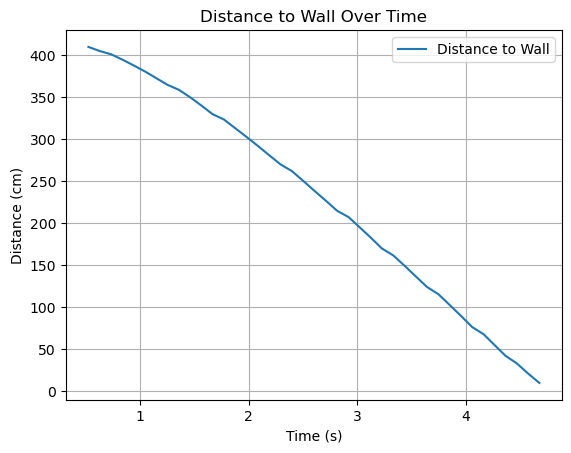

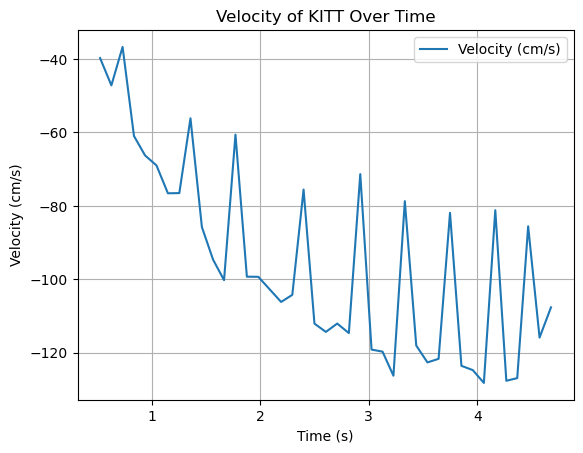

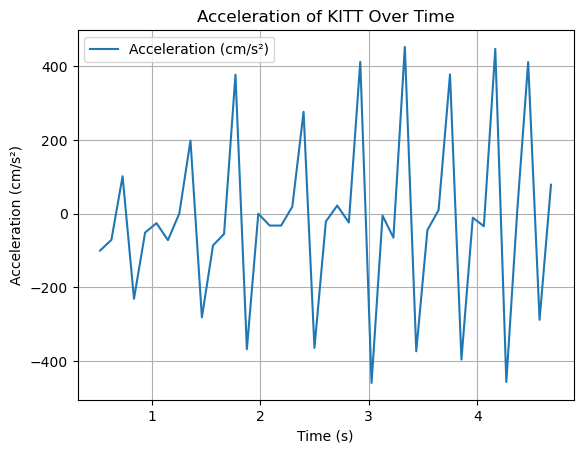

In [21]:
motor_command = b'M160\n'  # Example speed command

# Load the recorded data from the CSV file
data = pd.read_csv(f'Files/Recordings/kitt_distance_data_{motor_command[1:-1].decode()}.csv')

# Calculate average distance (left and right sensors)
data['Distance_Avg'] = (data['Distance_L'] + data['Distance_R']) / 2

# Calculate velocity (change in distance over time)
data['Velocity'] = data['Distance_Avg'].diff() / data['Time'].diff()

# Calculate acceleration (change in velocity over time)
data['Acceleration'] = data['Velocity'].diff() / data['Time'].diff()

# Discard the first few readings (inaccurate readings)
data = data.iloc[5:]

# Plotting Distance
plt.figure()
plt.plot(data['Time'], data['Distance_Avg'], label='Distance to Wall')
plt.xlabel('Time (s)')
plt.ylabel('Distance (cm)')
plt.title('Distance to Wall Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Velocity
plt.figure()
plt.plot(data['Time'], data['Velocity'], label='Velocity (cm/s)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.title('Velocity of KITT Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plotting Acceleration
plt.figure()
plt.plot(data['Time'], data['Acceleration'], label='Acceleration (cm/s²)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (cm/s²)')
plt.title('Acceleration of KITT Over Time')
plt.grid(True)
plt.legend()
plt.show()

### Step 4: Characteristics of the Distance Sensors
Write your own code and report on the following questions:
1. What is the accuracy of the distance sensors? How does it change with distance?
2. What are the minimum and maximum distances the sensors can measure?
3. What is the time resolution of the distance sensors? How old is a measurement by the time you receive it? What happens when you try to read the sensors too quickly?
4. What is the field of view of the distance sensors (beam angle)? How does it affect the measurements?
4. How do the distance sensors behave when KITT is moving towards a wall? What could you do to improve the resolution of the distance sensor readings? Is one of the sensors more accurate than the other?
5. How do the distance sensors behave when KITT is moving away from a wall? 

Note: Do not copy the questions into your report, but include the information in your report.

Tip to consider:

**Continuous Measurement** involves data that can be taken at any point in time, with no gaps. For example, a car’s speedometer provides a continuous record of the car’s speed. 

**Discrete Measurement**, on the other hand, collects data at specific intervals. For instance, KITT’s ultrasonic sensors take distance readings every 70 ms. In between these measurements, we don’t know the exact position of the car. Discrete data can still be useful, but it may miss details about rapid changes in speed or acceleration that occur between measurements. In order to interprete it correctly, you may need to filer or interpolate the data.

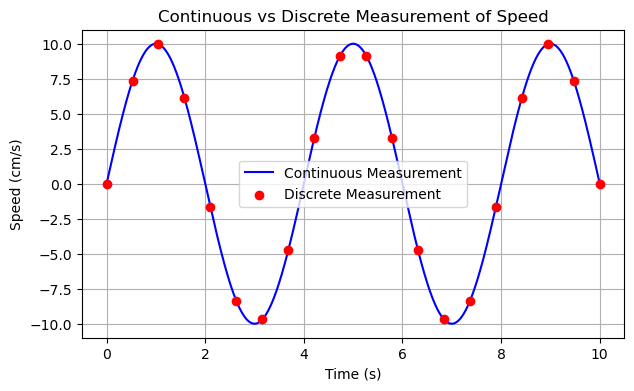

In [8]:
# Define time for continuous measurement (smooth, no gaps)
time_continuous = np.linspace(0, 10, 1000)  # Time from 0 to 10 seconds, 1000 data points
# Define time for discrete measurement (specific intervals)
time_discrete = np.linspace(0, 10, 20)  # Time from 0 to 10 seconds, 20 data points
# Simulate continuous speed (sinusoidal speed pattern for illustration)
speed_continuous = 10 * np.sin(0.5 * np.pi * time_continuous)  # Continuous speed
# Simulate discrete speed (sampled at specific intervals)
speed_discrete = 10 * np.sin(0.5 * np.pi * time_discrete)  # Discrete speed
# Plotting both continuous and discrete measurements
plt.figure(figsize=(7, 4))
# Plot continuous data
plt.plot(time_continuous, speed_continuous, label="Continuous Measurement", color="blue")
# Plot discrete data
plt.scatter(time_discrete, speed_discrete, label="Discrete Measurement", color="red", zorder=5)
# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.title('Continuous vs Discrete Measurement of Speed')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Implementing the distance sensor reading in your KITT class
In the previous module, you have created a class for KITT. Add a method to read the distance sensors to your KITT class in 'Student Code' files. You can use the code you have written in the previous steps to do this. Make sure to test your code. It is advisable to store all the old distance data in a list inside the KITT class. This will be convenient during the final challenge, where the route planning might need old measurements to determine the position of objects.

In [28]:
serial = Serial('/dev/ttyUSB0', 115200, rtscts=True, x=120, y=120)
serial.write(b'M160\n')
time.sleep(2)
serial.write(b'M150\n')
time.sleep(4)
serial.close()

Canvas(height=520, width=520)

### Step 6: Mid-term assessment 2.1 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your assigned TA. After you pass this assessment, you are ready to document your results in your midterm report. For this Module, you would include a chapter that covers the above tasks (using independently-readable text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made (i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before you discuss results and derive conclusions. Review the guidelines for more information. Include the corresponding code in an Appendix. Remember to document your code, using comments to define input/output variables of functions and to explain the logic and any modifications made. Your completed script will be crucial for the upcoming challenges, contributing to the overall autonomous driving system.

---

## 2. The Microphones

The field is equipped with four microphones at its corners, and a fifth microphone positioned at a higher level between two of the edge microphones. These microphones, together with the beacon mounted on KITT, will be used to locate KITT within the field (more details in Chapter 5).

<img src="pictures/axisdef.png" alt="Microphones Axis Defenition" width="400" height="240">

To use the microphone array, you must ensure that the correct sound card driver is installed. The sound card used in this project is the **PreSonus AudioBox 1818VSL**. Below are instructions on how to configure PyAudio and the necessary drivers on different platforms.

### Simulator
For the PyAudio package another simulator has been made. The simulator will return a realistic audio recoring, and change the recordings according to the location of the car. But, it contains only 1 recording, so it will not appear as random as the real car. It also does not adjust to your particular beacon settings. Make sure to test on the real car frequently. Use it in combination with the serial simulator to change locations and test like you would on the real car.

### PyAudio Installation and Setup

#### 1. **Linux and macOS (Intel-based)**:
On Linux and macOS (except for ARM versions like Apple Silicon), PyAudio works out of the box. Follow these steps to ensure it’s correctly installed:

- First, install PyAudio using `pip`:

```bash
pip3 install pyaudio
```

#### 2. **macOS (Apple Silicon - ARM)**:
For users on Apple Silicon (M1, M2), the ARM version of macOS, PyAudio needs to be installed via **Homebrew**. Follow these steps:

- First, install the PortAudio library (which PyAudio depends on) using Homebrew:

```bash
brew install portaudio
```

- Then, install PyAudio using `pip`:

```bash
pip3 install pyaudio
```

#### 3. **Windows 10**:
On Windows 10, additional setup is required because the PreSonus AudioBox 1818VSL uses ASIO drivers, and PyAudio doesn’t support ASIO out of the box. Follow these steps:

- Download and install [ASIO4ALL](https://www.asio4all.org/).
- Download a special build of PyAudio with ASIO support from [Gohlke’s Unofficial Windows Binaries](https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyaudio).
- After downloading the correct `.whl` file, install it using `pip`:

```bash
pip install path_to_downloaded_wheel.whl
```

Make sure to use the audio device index that has ASIO in the name. Other audio devices may be using the legacy MME or WDM Windows drivers, which may not support more than 2 synchronous audio channels.

#### 4. **Windows 11**:
On Windows 11, the PreSonus AudioBox 1818VSL works without additional drivers, and PyAudio can be installed using `pip`:

```bash
pip install pyaudio
```

### Important: Lab Rules for the Microphone Array

When working with the microphone array, please follow these rules to ensure smooth operations and avoid disrupting other groups:

1. **Do not rearrange the microphone connectors**. The setup is shared between multiple groups, and changing the connections may lead to incorrect results for other teams.
2. **Do not touch the volume settings**. If the volume needs adjustment, contact a TA for assistance.
3. **Handle the equipment carefully**. The microphone array and associated hardware are sensitive, and mishandling could cause damage.
4. **Start on stop on time**. The lab is shared, and other groups have scheduled time slots. Be respectful of their time.

There is limited test time, we know this. But by using the simulator and having a plan of what you want to test during each scheduled slot, it is enough time to complete the tasks. 

### Step 1: Initializing the Microphone Array

Before using the microphone array, it must first be initialized. As part of the initialization process, you will need to specify the sampling frequency (`Fs`) that will be used to record the audio. The sampling frequency will vary based on the test field you are working with, and it will be **48 kHz** or **44.1 kHz**.

A typical laptop or PC may have multiple audio devices (e.g., built-in microphones, Bluetooth headsets, external sound cards). To ensure that the correct device is used, you can list all available audio devices using PyAudio and select the appropriate one. Use the following code snippet to list all audio devices recognized by PyAudio and find the index of the PreSonus AudioBox 1818VSL or any other relevant device:

In [29]:
pyaudio_handle = PyAudio()
for i in range(pyaudio_handle.get_device_count()):
    device_info = pyaudio_handle.get_device_info_by_index(i)
    print(i, device_info['name'])


0 iPhone Microphone
1 AudioBox 1818 VSL
2 MacBook Pro Microphone
3 MacBook Pro Speakers
4 Microsoft Teams Audio


Once you have identified the index of the microphone array device from the list, you can initialize it by specifying the device index (`device_index`) and the desired sampling frequency (`Fs`).

Here’s how you can open the audio stream using PyAudio:

In [23]:
# Initialize PyAudio again
pyaudio_handle = PyAudio()

# Specify the device index and sampling frequency
device_index = 1 # Replace with the index of your microphone device
Fs = 48000  # or 44100, depending on the field setup

# Open the audio stream with 5 channels, 16-bit audio format (paInt16), and the specified sample rate
stream = pyaudio_handle.open(input_device_index=device_index,
                             channels=5,
                             format=paInt16,
                             rate=Fs,
                             input=True)

### Step 2: Recording Audio Data

To make a recording with the microphone array, you must specify the **length of the recording** as the number of **audio frames** to capture. Each audio frame consists of samples from all 5 microphones. Given that we are using 16-bit audio (2 bytes per sample), each frame will contain **10 bytes** (5 microphones × 2 bytes per sample).

Thus, recording **N frames** will produce **10N bytes** of data. Note: The simulator returns a fixed length recording at 44.1 kHz. The real car will return a recording of the length you specify.

The following command records `N` frames from the microphone array and stores the result as a bytes object:

In [24]:
Fs = 44100  # Sampling frequency
N = 2*Fs  # 2 seconds of audio data
samples = stream.read(N)

#### Converting Audio Data to Numpy Array

The raw audio data returned from `stream.read()` is stored in a **bytes** object. To work with the data more easily (e.g., for analysis or plotting), it should be converted into a **Numpy array**:

In [25]:
data = np.frombuffer(samples, dtype='int16')

At this point, the microphone data is **interleaved**. This means that the first value (`data[0]`) corresponds to the first sample of microphone 0, the second value (`data[1]`) corresponds to the first sample of microphone 1, and so on. For example, `data[5]` contains the second sample of microphone 0, and the pattern continues. To visualize the interleaving of the data, refer to the table below:

| data[0] | data[1] | data[2] | data[3] | data[4] | data[5] | data[6] | data[7] | ... |
|---------|---------|---------|---------|---------|---------|---------|---------|-----|
| mic 0   | mic 1   | mic 2   | mic 3   | mic 4   | mic 0   | mic 1   | mic 2   | ... |
| frame 0 | frame 0 | frame 0 | frame 0 | frame 0 | frame 1 | frame 1 | frame 1 | ... |

#### Deinterleaving the Data

To work with the data from each microphone independently, the **interleaved data** must be split into separate streams for each microphone. This process is called **deinterleaving**.

Write a function to deinterleave the audio data and store the samples from each microphone in a separate Numpy array:

In [26]:
# Assuming `data` is the interleaved Numpy array of int16 samples
num_mics = 5

# Reshape the data into a matrix with 5 columns (one for each microphone)
deinterleaved_data = np.reshape(data, (-1, num_mics))

# Now each column corresponds to the data for one microphone
mic_0_data = deinterleaved_data[:, 0]
mic_1_data = deinterleaved_data[:, 1]
mic_2_data = deinterleaved_data[:, 2]
mic_3_data = deinterleaved_data[:, 3]
mic_4_data = deinterleaved_data[:, 4]

### Plotting the Audio Data

Once you've extracted the audio data for each microphone, you can plot it using Python. **Matplotlib** is a commonly used module for creating plots. Plot the audio data from each microphone to visualize the sound captured by the microphone array:

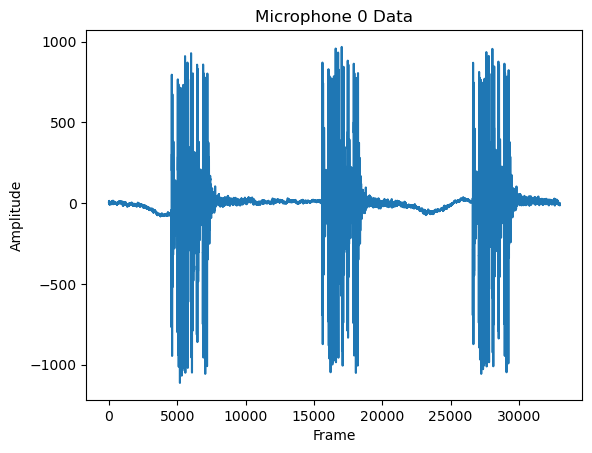

In [27]:
plt.plot(mic_0_data)
plt.title('Microphone 0 Data')
plt.xlabel('Frame')
plt.ylabel('Amplitude')
plt.show()

### Step 3: Testing the Microphone Array
Below are some experiments you can perform to test the microphone array, and develop the code.

**Part 1: Clapping** : With the real microphones connected, have your teammate clap in front of each microphone in turn. Record the audio data and plot the results. Is the order of the microphones what you expected? How does the sound intensity change as you move from one microphone to another?

**Part 2: Beacon Detection** : Turn on KITT's beacon and record the results. Can you identify where KITT is located just by observing the shift in the recordings? Change the beacons parameters and see how it affects the recordings.

**Part 3: Ideal OOK signal** : Compare the waveform of the recording to an ideal OOK of your code.  What can you see, and what do you infer from this? Are some beacon signals better than others? How can you find a good beacon signal?

**Part 4: Reference recording** : Make some recordings of the beacon at different locations. These recordings will be usefull to your teammates working on the localization algorithm. Simillarly, make a recording of a single pulse from the beacon close to one of the microphones. Cut out the pulse and save it seperatly.

**Part 5: KITT class** : Add a method to read the microphones to your KITT class in 'Student Code' files. The method should make a stream, turn on the beacon, start the recording, stop the recording, and turn off the beacon. You can choose to return the recording as a result, or store it internally inside the KITT class. Make sure to test your code.

*Bonus Tasks - Optional*

- See if you can automate selecting the correct PyAudio device index. The correct device index changes from one computer to another and can sometimes even change on the same computer after a reboot. So, it is worth your time to make a program that can automatically select the right device index.
- Implement start-up sanity checks: some process which you can run after you arrive at the test field, so that you can quickly check the microphone connections and audio levels.
- Explore PyAudio’s callback mode. This manual describes what is called ‘blocking mode’. The stream.read() function will block your program until the requested number of frames has been received from the sound card. You can instead specify a callback function to process new audio frames as they arrive. If done carefully, this will allow your program to respond faster to new microphone samples, and enable you to drive while recording. You can read more about call-back mode in the official [PyAudio documentation](https://people.csail.mit.edu/hubert/pyaudio/docs/)




### Mid-term assessment 2.2 and report

After you finish this assignment, and ultimo in week 4, showcase the functionality of your script to your
assigned TA. After you pass this assessment, you are ready to document your results in your midterm
report.

For this Module, you would include a chapter that covers the above tasks (using independently-readable
text, i.e., don’t refer to “Task 1”). Include plots; for each plot it should be clear how the plot was made
(i.e., the corresponding experimental set-up), and you have to describe what is seen in the plot before
you discuss results and derive any conclusions. Be sure to answer the questions posed along with the
plots (using independently-readable text).

Include the corresponding code in an Appendix. Remember to document your code, using comments
to define input/output variables of functions and to explain the logic and any modifications made. Your
completed script will be crucial for the upcoming challenges, contributing to the overall autonomous
driving system.

This concludes the mid-term assignments related to communication with KITT. After the mid-term, you
must integrate this module with the localization module created by your colleagues. Take into account
that integrating is often harder than originally anticipated, e.g. your code has to run in parallel, and you
have to worry about timing aspects. Hopefully, using the KITT class will provide you with a sturdy and
flexible framework to continue your work towards the final challenge


FAQ



**What is the beam angel ?**

The beam angle of a sensor refers to how wide the sensor's detection area is. It determines how much space the sensor can cover when it sends out signals (like sound or light) to detect objects.

To determine the beam angle of ultrasonic sensors mounted in front of the car, you have multiple options: 

1. **Check the Sensor Datasheet**: The easiest way or at least a way to get some idea to determine the beam angle is to refer to the manufacturer's datasheet for your specific ultrasonic sensor. The datasheet will typically provide the beam angle, often around 15 to 30 degrees for common ultrasonic sensors. But keep in mind that is for a single sensor and not the current set up ! 

2. **Experimental Determination for KIIT**:
   - **Measure Detection Width**: Place a flat object (like a wall) at a fixed distance in front of the sensor (e.g., 1 meter).
   - **Move the Object**: Move the object left and right to determine the points where the sensor stops detecting the object.
   - **Calculate the Angle**: Measure the distance between these two points (detection width) and the distance from the sensor to the object. You may use the following formula:

   
     $$\
     \text{Beam Angle} = 2 \times \arctan\left(\frac{\text{Detection Width}/2}{\text{Distance to Object}}\right)
     \
   - This calculation will give you the beam angle in degrees.$$


   **Here comes a picture** 


**I see random numbers from sensors for large distances is my sensor damaged ?**

During experiments, you may occasionally receive random or unexpected data from the sensors. This can occur not only when the sensors are operating outside their effective range but also at times when they are within range. Several factors (consider what they might be?) can cause ultrasonic sensors to produce inaccurate readings. Additionally, since there are two sensors—one on the left and one on the right—they might produce different, completly different readings.


**Are the measuremnts done from ultra sonic sesnors on the left and the right side excatly at the same time ?**

If you closely observe the blinking of the small LEDs on the Ultrasonic board on the car, you might notice that they turn on and off alternately. This indicates a slight time difference in the sensor measurements. While you don't necessarily need to account for this, as other sources of inaccuracy are more apparent, this delay is also noticeable and can be measured.

**When I try to plot the distance it seems that numbers on the axis of the plot are not in order or I have some distances shown two times . There is nothing wrong with my plots and the python code runs. What could be the issue ?**

If you notice that some numbers are repeated or that the sequence of numbers on the axis seems incorrect, review your data extraction process. Ensure that you are printing the numbers as floats rather than characters!